In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import backbone.Custom as cust
import backbone.VISUAL as viz
import importlib
import matplotlib.pyplot as plt
import backbone.AstroMLmod as AstroMLmod
import numpy as np
import backbone.TwoNN as TwoNN
import time
import h5py
import skdim
    
importlib.reload(cust)
importlib.reload(viz)
importlib.reload(AstroMLmod)


def get_data_loaders(Dir = "some/directory", batch_size = 32):

    #obtain  data from a folder a of images
    dataset = torchvision.datasets.ImageFolder(Dir)
    names = [name[0].split('/')[-1] for name in dataset.imgs]
    transformed_dataset = cust.Custom_labelled(dataset,names =names,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.30)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

def perturb_list_by_swapping(lst, percentage=5):
    num_swaps = max(1, int(len(lst) * (percentage / 100)))  # Ensure at least one swap
    perturbed_lst = lst[:]  # Copy the list to avoid modifying the original

    for _ in range(num_swaps):
        i, j = random.sample(range(len(lst)), 2)  # Pick two distinct indices
        perturbed_lst[i], perturbed_lst[j] = perturbed_lst[j], perturbed_lst[i]  # Swap them
    
    return perturbed_lst


def galaxyzoo10(batch_size = 256):

    # To get the images and labels from file
    with h5py.File('Galaxy10_DECals.h5', 'r') as F:
        images = np.array(F['images'])
        labels = np.array(F['ans'])
        ids = np.array(F['ra'])
    
    # To convert the labels to categorical 10 classes

    # To convert to desirable type
    labels = labels.astype(np.int64)
    labels = perturb_list_by_swapping(labels, percentage=5)
    images = images.astype(np.float32)
    

    transformed_dataset = cust.ArrayDataset(images = images,labels =labels,names = ids,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.30)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)

    return train_loader, test_loader




def train_resnet(num_epochs=100, learning_rate=0.0005, Dir ="galaxy_zoo_class_new", batch_size=128, device='cuda'):

    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))
    plt.rcParams.update({'font.size': 20}) 


    train_loader, test_loader = galaxyzoo10(batch_size = batch_size)
    
    model = models.efficientnet_b0(weights = "IMAGENET1K_V1")

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #get_representations(model = model,loader = train_loader, batch_size = batch_size, epoch = 0,device  = device)
    model.classifier[1]= nn.Linear(model.classifier[1].in_features, 10) 
    #randomize the weights of the newly added sub-layers
    model.classifier[1].weight.data.normal_(0,0.01)
    model = model.to(device)

    intrinsic_dimension = []
    validation_accuracy = []
    train_accuracy = []

    #Obtain train and test accuracies
    
    train, val = evaluate(model, train_loader, test_loader, device)

    #get representatations
    test_representations = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)

    #conpute the id_score
    id_score,std = AstroMLmod.id_score(test_representations)
    
    intrinsic_dimension.append((id_score,std))
    
    validation_accuracy.append(val)
    train_accuracy.append(train)
    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))


    
    for epoch in range(1,num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, names in train_loader:
            
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        model.eval()
        
        train, val = evaluate(model, train_loader, test_loader, device)
        #save classification layer for next epoch
        
        class_layer = model.classifier
        
        test_representations = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)

        #conpute the id_score
        id_score,std = AstroMLmod.id_score(test_representations)
    
        intrinsic_dimension.append((id_score,std))
        y, yerr = zip(*intrinsic_dimension)


        #Faltten the manifold
        #flat_rep = viz.umap(test_representations,name = "Features on epoch:"+str(epoch))

        #AstroMLmod.correlate_and_plot(flat_rep,min_dist = 0.0, max_dist =2.5, label = "Correlation on flat manifold for epoch:"+str(epoch))

        

        validation_accuracy.append(val)
        train_accuracy.append(train)

        #model.fc = nn.Linear(512, 10) 
        model.classifier = class_layer
        #model.fc = model.fc.to(device)
        x = np.arange(epoch+1)
        plt.plot(y, label = "ID score", color = "blue")
           
        plt.errorbar(x, y, yerr=yerr, fmt='o', color = "blue", capsize=1)


        plt.plot([100-a for a in validation_accuracy], label = "validation error")
        plt.plot([100-a for a in train_accuracy], label = "Train error")
        plt.xlabel("Epoch")
        plt.legend(loc="upper right")
        plt.show()
       
    import pickle

    pkl_filename = "bad_intrinsic_dimension.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(intrinsic_dimension,file)
        
    pkl_filename = "bad_validation.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(validation_accuracy,file)
        
    pkl_filename = "bad_train.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(train_accuracy,file) 


    #evaluate(model, train_loader, test_loader, device)

def evaluate(model, train_loader,test_loader, device):
            
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    print(f'Train Accuracy: {100 * correct / total:.2f}%')
    train_accuracy = 100 * correct / total

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    test_accuracy = 100 * correct / total
    torch.cuda.empty_cache()
    return train_accuracy, test_accuracy

if __name__ == "__main__":
    train_resnet()

/users/koketso/.venv/deepclustering3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-27 14:41:01.448168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743079262.018148 1596783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743079262.134674 1596783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 14:41:02.856152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




NameError: name 'random' is not defined

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

pkl_filename = "intrinsic_dimension.csv"
with open(pkl_filename, 'rb') as file:
    i_d= pickle.load(file)
        
pkl_filename = "validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_accuracy = pickle.load(file) 

pkl_filename = "train.csv"
with open(pkl_filename, 'rb') as file:
    train_accuracy = pickle.load(file) 

y,yerr = zip(*i_d)
x = range(len(y))
yerr = np.array(yerr)
y = np.array(y)
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.plot(y, label = "ID score", color = "blue")
plt.fill_between(x, y - yerr, y + yerr, color="blue", alpha=0.3)

plt.plot([(100-a)/5 for a in validation_accuracy], label = "Validation error/5")
plt.plot([(100-a)/5 for a in train_accuracy], label = "Train error/5")
plt.xlabel("Epoch")
plt.ylim(0,20)

plt.legend(loc="upper right")
plt.show()

<Figure size 1920x1440 with 0 Axes>

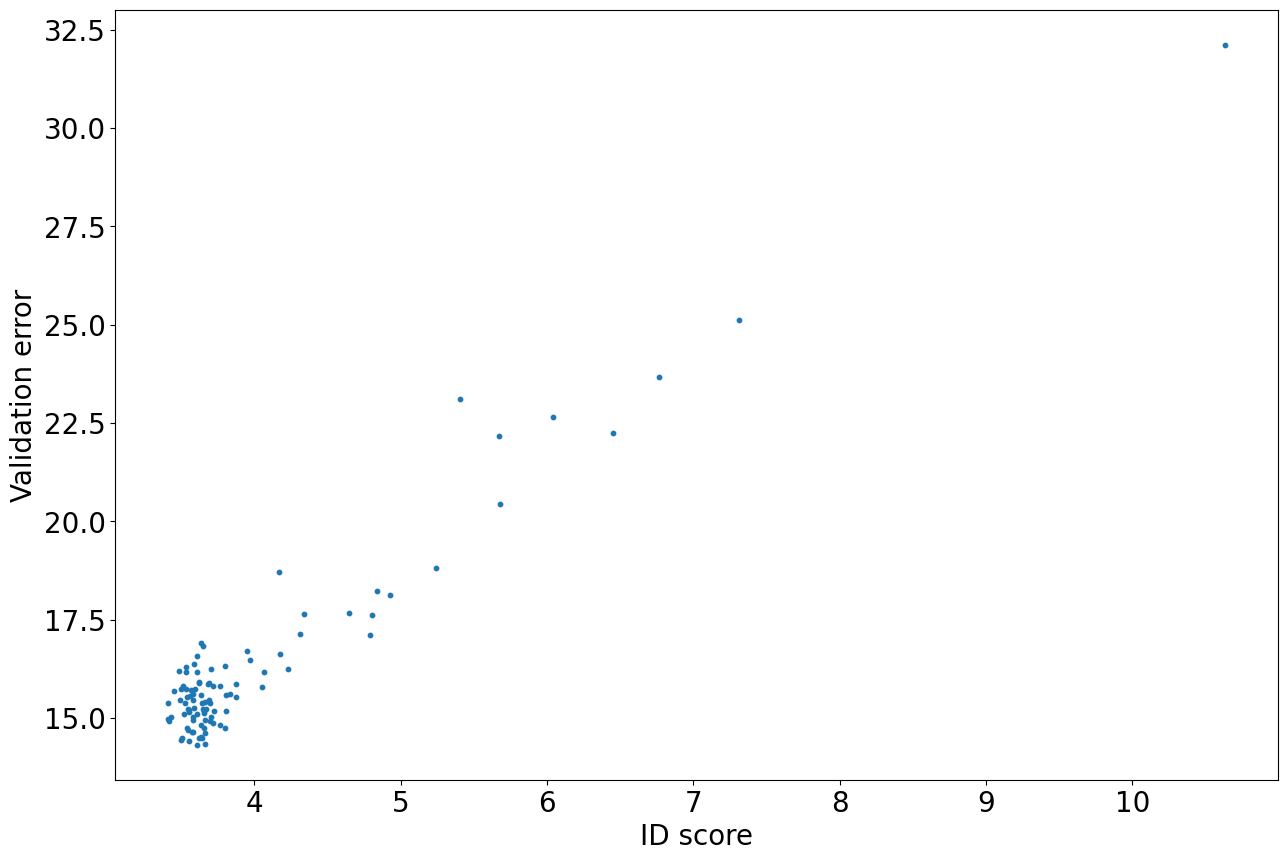

In [17]:
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.scatter(y[1:],[(100-a) for a in validation_accuracy][1:], s = 10)
plt.xlabel("ID score")
plt.ylabel("Validation error")
plt.show()

In [57]:
import random


# Example usage
original_list = list(range(10000))
perturbed_list = perturb_list_by_swapping(original_list)


sum(int(a==b) for a,b in zip(original_list,perturbed_list))

9041

In [24]:
import random
a = np.array([np.array([1231])])
indices = random.sample(range(1),int(1))
indices
a[indices]

array([[1231]])

In [4]:
import torchvision as tv
print(tv.models.efficientnet_b0())

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat